In [182]:
import os
import numpy as np
import pandas as pd
from PIL import Image
from pathlib import Path
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import Sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, BatchNormalization
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img
from tensorflow.keras.metrics import BinaryAccuracy, Precision, Recall, AUC, MeanSquaredError, MeanAbsoluteError
from tensorflow.keras.losses import BinaryCrossentropy, MeanSquaredError




Read training images and labels 

In [183]:
def get_dataset_path():
    # Check if running in Kaggle
    if 'KAGGLE_KERNEL_RUN_TYPE' in os.environ:
        # Running in Kaggle kernel
        return '/kaggle/input/machine-learning-in-science-ii-2024'
    else:
        # Running in a standalone Python script or Jupyter notebook
        return Path(__file__).parent

In [184]:
# Example usage:
dataset_path = get_dataset_path()
print(f"Dataset path: {dataset_path}")
print(f"{dataset_path}/training_data/training_data")
print(f"{dataset_path}/test_data/test_data")


Dataset path: /kaggle/input/machine-learning-in-science-ii-2024
/kaggle/input/machine-learning-in-science-ii-2024/training_data/training_data
/kaggle/input/machine-learning-in-science-ii-2024/test_data/test_data


In [185]:
def construct_images_path(directory_with_images):
    filenames = os.listdir(directory_with_images) 
    images_path = []
    if any ('.png' in filename for filename in filenames):
        for index, current_filename in enumerate(filenames):
            image_path = f"{directory_with_images}/{current_filename}"
            images_path.append(image_path)
            
    return images_path
    

In [186]:
def build_images_path(dataset_directory):
    training_images_directory = f"{dataset_directory}/training_data/training_data"
    test_images_directory = f"{dataset_directory}/test_data/test_data"
    training_images_path = construct_images_path(training_images_directory)
    test_images_path = construct_images_path(test_images_directory)
    return training_images_path,test_images_path

train_img, test_img = build_images_path(dataset_path)
print(f"Dataset path: \n{train_img[0]} \n{test_img[0]}")

Dataset path: 
/kaggle/input/machine-learning-in-science-ii-2024/training_data/training_data/9273.png 
/kaggle/input/machine-learning-in-science-ii-2024/test_data/test_data/1017.png


In [187]:
def get_csv_labels(dataset_directory):
    training_labels_relative_path = f"{dataset_directory}/training_norm.csv" # data frame path
    training_labels = pd.read_csv(training_labels_relative_path)   # store the labels
    return training_labels

training_labels = get_csv_labels(dataset_path)
print(training_labels)

       image_id   angle  speed
0             1  0.4375    0.0
1             2  0.8125    1.0
2             3  0.4375    1.0
3             4  0.6250    1.0
4             5  0.5000    0.0
...         ...     ...    ...
13788     13794  0.6250    1.0
13789     13795  0.4375    1.0
13790     13796  0.5625    0.0
13791     13797  0.6250    0.0
13792     13798  0.6875    1.0

[13793 rows x 3 columns]


# Preprocessing.
Removing corrupted images.

In [188]:
def find_corrupted_images(image_paths):
    corrupted_indices = []

    for i, image_path in enumerate(image_paths):
        try:
            # Attempt to open the image
            with Image.open(image_path) as img:
                # Perform any additional checks if needed
                pass
        except (IOError, OSError, Exception) as e:
            # Extract the index from the image_path
            index = int(image_path.split('/')[-1].split('.png')[0])
            # Handle the error (consider the image as corrupted)
            print(f"Error opening image {index}.png: {e}")
            corrupted_indices.append(index)
    return corrupted_indices

# Find corrupted images
corrupted_indices = find_corrupted_images(train_img)

# Print the indices of corrupted images
print("Corrupted Image Indices:", corrupted_indices)

Error opening image 10171.png: cannot identify image file '/kaggle/input/machine-learning-in-science-ii-2024/training_data/training_data/10171.png'
Error opening image 3141.png: cannot identify image file '/kaggle/input/machine-learning-in-science-ii-2024/training_data/training_data/3141.png'
Error opening image 3999.png: cannot identify image file '/kaggle/input/machine-learning-in-science-ii-2024/training_data/training_data/3999.png'
Error opening image 4895.png: cannot identify image file '/kaggle/input/machine-learning-in-science-ii-2024/training_data/training_data/4895.png'
Error opening image 8285.png: cannot identify image file '/kaggle/input/machine-learning-in-science-ii-2024/training_data/training_data/8285.png'
Corrupted Image Indices: [10171, 3141, 3999, 4895, 8285]


In [189]:

def remove_corrupted_data(training_labels, image_paths, corrupted_indices):
    # Extract the 'image_id' column from the original DataFrame
    image_ids = training_labels['image_id']

    # Identify the 'image_id' values for the corrupted images
    corrupted_image_ids = image_ids.iloc[corrupted_indices].tolist()

    # Check if each 'image_id' is in the list of corrupted 'image_id' values
    is_not_corrupted = ~image_ids.isin(corrupted_image_ids)

    # Filter the original DataFrame
    data_labels_cleaned = training_labels[is_not_corrupted]

    # Reset the index of the cleaned DataFrame
    data_labels_cleaned = data_labels_cleaned.reset_index(drop=True)

    # Remove corresponding image paths for corrupted images
    image_paths_cleaned = [path for path, image_id in zip(image_paths, image_ids) if image_id not in corrupted_image_ids]

    # Return cleaned DataFrame and image paths
    return data_labels_cleaned, image_paths_cleaned


data_labels_cleaned, image_paths_cleaned = remove_corrupted_data(training_labels, train_img, corrupted_indices)
print(f': Labels: {len(data_labels_cleaned)} ? {len(training_labels)}')
print(f': Images: {len(image_paths_cleaned)} ? {len(train_img)}')
# Find corrupted images


: Labels: 13788 ? 13793
: Images: 13788 ? 13798


Check for incorect data.

In [190]:
def remove_invalid_speed_data(data_labels, image_paths):
    # Filter rows where 'speed' is 0 or 1
    valid_speed_rows = data_labels[(data_labels['speed'] == 0) | (data_labels['speed'] == 1)]

    # Reset the index of the cleaned DataFrame
    valid_speed_rows = valid_speed_rows.reset_index(drop=True)

    # Extract the 'image_id' column from the original DataFrame
    image_ids = valid_speed_rows['image_id']
    
    image_id_path_pairs = zip(image_ids, image_paths)
    cleaned_image_paths = []
    for image_id, path in image_id_path_pairs:
        cleaned_image_paths.append(path)

    # Return cleaned DataFrame and corresponding image paths
    return valid_speed_rows, cleaned_image_paths

data_labels_cleaned2, image_paths_cleaned2 = remove_invalid_speed_data(data_labels_cleaned, image_paths_cleaned)
print(f': Labels: {len(data_labels_cleaned2)} ? {len(data_labels_cleaned)}')
print(f': Images: {len(image_paths_cleaned2)} ? {len(image_paths_cleaned)}')

: Labels: 13787 ? 13788
: Images: 13787 ? 13788


Visual Inspection: 

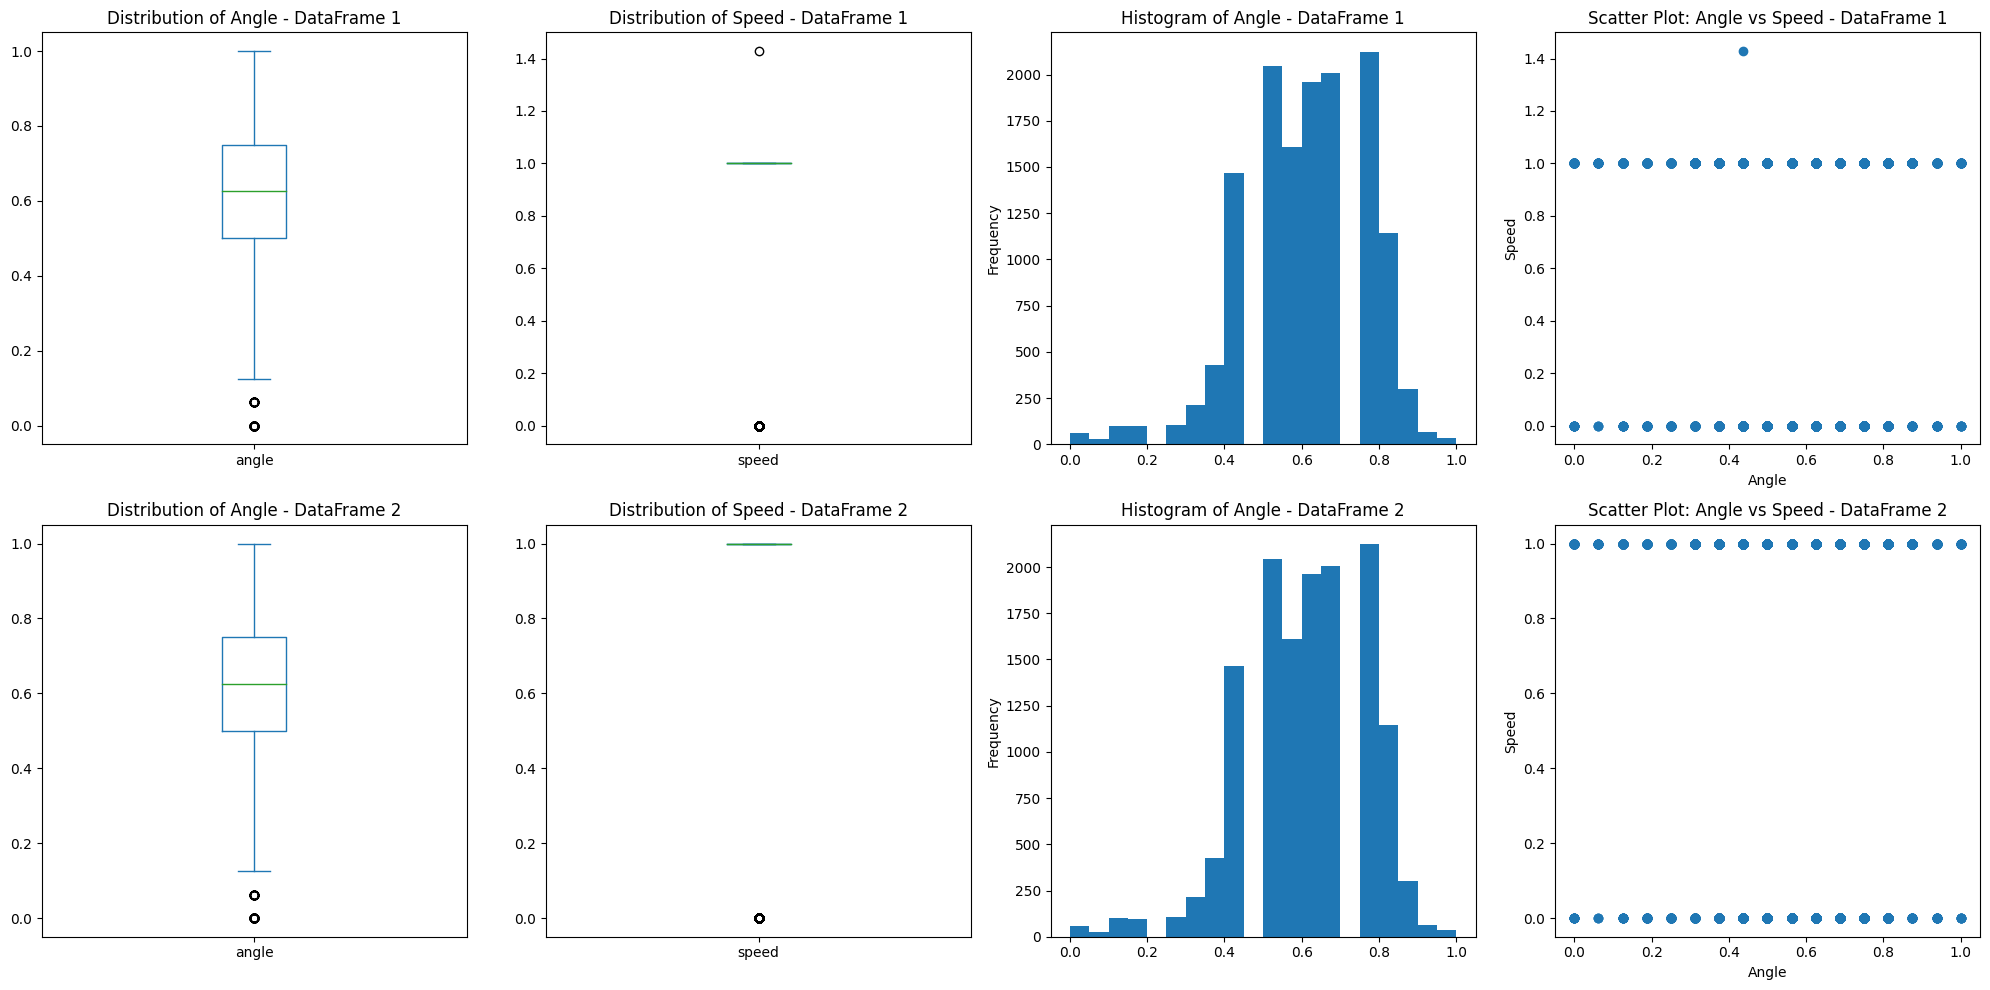

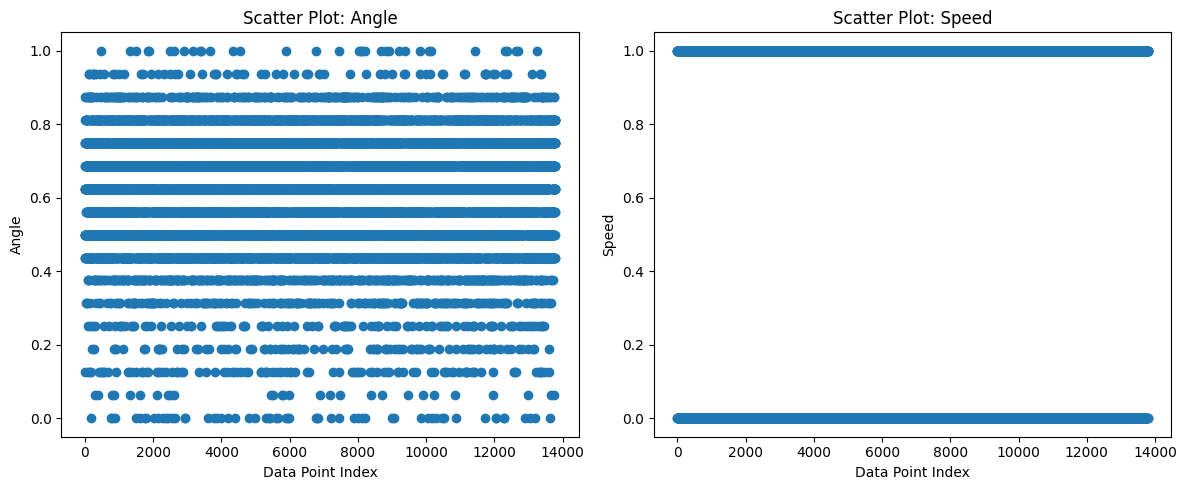

In [191]:
# Create a figure and axes for subplots
fig, axes = plt.subplots(2, 4, figsize=(20, 10))

# Plot the first box plot for 'angle'
data_labels_cleaned['angle'].plot(kind='box', ax=axes[0, 0])
axes[0, 0].set_title('Distribution of Angle - DataFrame 1')

# Plot the first box plot for 'speed'
data_labels_cleaned['speed'].plot(kind='box', ax=axes[0, 1])
axes[0, 1].set_title('Distribution of Speed - DataFrame 1')

# Histogram for 'angle' in DataFrame 1
data_labels_cleaned['angle'].plot(kind='hist', bins=20, ax=axes[0, 2])
axes[0, 2].set_title('Histogram of Angle - DataFrame 1')

# Scatter plot of 'angle' against 'speed' in DataFrame 1
axes[0, 3].scatter(data_labels_cleaned['angle'], data_labels_cleaned['speed'])
axes[0, 3].set_title('Scatter Plot: Angle vs Speed - DataFrame 1')
axes[0, 3].set_xlabel('Angle')
axes[0, 3].set_ylabel('Speed')

# Plot the second box plot for 'angle'
data_labels_cleaned2['angle'].plot(kind='box', ax=axes[1, 0])
axes[1, 0].set_title('Distribution of Angle - DataFrame 2')

# Plot the second box plot for 'speed'
data_labels_cleaned2['speed'].plot(kind='box', ax=axes[1, 1])
axes[1, 1].set_title('Distribution of Speed - DataFrame 2')

# Histogram for 'angle' in DataFrame 2
data_labels_cleaned2['angle'].plot(kind='hist', bins=20, ax=axes[1, 2])
axes[1, 2].set_title('Histogram of Angle - DataFrame 2')

# Scatter plot of 'angle' against 'speed' in DataFrame 2
axes[1, 3].scatter(data_labels_cleaned2['angle'], data_labels_cleaned2['speed'])
axes[1, 3].set_title('Scatter Plot: Angle vs Speed - DataFrame 2')
axes[1, 3].set_xlabel('Angle')
axes[1, 3].set_ylabel('Speed')

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()
# Create a figure and axes for subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Scatter plot for 'angle'
axes[0].scatter(range(len(data_labels_cleaned2['angle'])), data_labels_cleaned2['angle'])
axes[0].set_title('Scatter Plot: Angle')
axes[0].set_xlabel('Data Point Index')
axes[0].set_ylabel('Angle')

# Scatter plot for 'speed'
axes[1].scatter(range(len(data_labels_cleaned2['speed'])), data_labels_cleaned2['speed'])
axes[1].set_title('Scatter Plot: Speed')
axes[1].set_xlabel('Data Point Index')
axes[1].set_ylabel('Speed')

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

# CNN MODEL


In [193]:
def create_cnn_model_v3(image_shape, pool_size=(2, 2)):
    """
    Creates two CNN models with the specified input shape.
    """
    model_speed = Sequential([
        Input(shape=image_shape + (3,), name='input_speed'),
        Conv2D(32, (5, 5), activation='relu'),
        MaxPooling2D(pool_size=pool_size),
        Conv2D(64, (5, 5), activation='relu'),
        MaxPooling2D(pool_size=pool_size),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=pool_size),
        Conv2D(256, (3, 3), activation='relu'),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(32, activation='relu'),
        Dropout(0.5),
        Dense(10, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid', name='output_speed')  # Output layer for 'speed'
    ], name='model_speed')

    model_angle = Sequential([
        Input(shape=image_shape + (3,), name='input_angle'),
        Conv2D(32, (5, 5), activation='relu'),
        MaxPooling2D(pool_size=pool_size),
        Conv2D(64, (5, 5), activation='relu'),
        MaxPooling2D(pool_size=pool_size),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=pool_size),
        Conv2D(256, (3, 3), activation='relu'),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(32, activation='relu'),
        Dropout(0.5),
        Dense(10, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='linear', name='output_angle')  # Output layer for 'angle'
    ], name='model_angle')

    print("Model Speed Summary:")
    model_speed.summary()
    
    print("\nModel Angle Summary:")
    model_angle.summary()
    
    return model_speed, model_angle


# Data Generator class.

In [194]:
class CustomDataGenerator(Sequence):
    def __init__(self, data_frame, batch_size, image_shape, output_label, augmentations=None, shuffle=True):
        self.data_frame = data_frame
        self.batch_size = batch_size
        self.image_shape = image_shape
        self.output_label = output_label
        self.augmentations = augmentations
        self.shuffle = shuffle
        self.indexes = np.arange(len(self.data_frame))

    def __len__(self):
        return int(np.ceil(len(self.data_frame) / self.batch_size))

    def __getitem__(self, index):
        start = index * self.batch_size
        end = (index + 1) * self.batch_size
        batch = self.data_frame.iloc[start:end]
        images = [self.load_and_augment_image(row['image_path']) for _, row in batch.iterrows()]
        images = np.array(images)
        output_values = batch[self.output_label].values

        return images, {'output_label': output_values}

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def load_and_augment_image(self, image_path):
        # Load the image
        img = load_img(image_path, target_size=self.image_shape)

        # Resize the image to the target size
        img = array_to_img(img_to_array(img).resize(self.image_shape))

        # Convert the image to a NumPy array
        img = img_to_array(img)

        # Apply augmentations if specified
        if self.augmentations:
            img = self.augmentations.random_transform(img)

        # Normalize to [0, 1]
        img = img / 255.0

        return img


In [195]:
def create_data_generator(data_set, batch_size, image_shape, augmentations=None, output_label='speed'):
    return CustomDataGenerator(data_set, batch_size, image_shape, output_label, augmentations)

# Training

In [196]:
def build_training_validation_and_evaluation_sets(train_image_paths, image_shape, batch_size, eval_split, train_val_split):

    # Split into training and validation sets
    train_set, val_set = train_test_split(train_image_paths, test_size=train_val_split[1], random_state=42)

    # Split validation set into evaluation sets for speed and angle
    eval_set_speed, eval_set_angle = train_test_split(val_set, test_size=eval_split, random_state=42)

    # Additional processing as needed (e.g., loading images, data augmentation)

    # Print summary
    print(f"\nFound {len(train_image_paths)} images.")
    print(f"Using {len(train_set)} ({round(len(train_set) / len(train_image_paths) * 100, 1)}%) for training.")
    print(f"Using {len(val_set)} ({round(len(val_set) / len(train_image_paths) * 100, 1)}%) for validation.")
    print(f"Using {len(eval_set_speed)} ({round(len(eval_set_speed) / len(train_image_paths) * 100, 1)}%) for evaluation of speed.")
    print(f"Using {len(eval_set_angle)} ({round(len(eval_set_angle) / len(train_image_paths) * 100, 1)}%) for evaluation of angle.")

    # Additional return statements as needed
    return train_set, val_set, eval_set_speed, eval_set_angle

In [197]:
# DATA HYPERPARAMETERS
batch_size = 64
image_shape = (int(320/2), int(240/2)) # half the real size of the image.
eval_split = 0.1
train_val_split = [0.8, 0.2]
# TRAINING HYPERPARAMETERS 
learning_rate = 0.001  # Specify your desired learning rate
epochs = 200
logging = True # Set to True, the training process might log various metrics (such as loss and accuracy) for visualization and analysis using TensorBoard.
pool_size=(2, 2)



In [198]:
train_images = image_paths_cleaned2
data_labels = data_labels_cleaned2
train_set, val_set, eval_set_speed, eval_set_angle = build_training_validation_and_evaluation_sets(train_images,
                                                                   image_shape,
                                                                   batch_size,
                                                                    eval_split,
                                                                   train_val_split  )
model_speed, model_angle = create_cnn_model_v3(image_shape, pool_size)


Found 13787 images.
Using 11029 (80.0%) for training.
Using 2758 (20.0%) for validation.
Using 2482 (18.0%) for evaluation of speed.
Using 276 (2.0%) for evaluation of angle.
Model Speed Summary:


Model: "model_speed"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_24 (Conv2D)              │ (None, 156, 116, 32)   │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 78, 58, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 74, 54, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 37, 27, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 35, 25, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 17, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 15, 10, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 38400)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 128)            │     4,915,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 10)             │           330 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_speed (Dense)            │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,348,725 (20.40 MB)

 Trainable params: 5,348,725 (20.40 MB)

 Non-trainable params: 0 (0.00 B)


Model Angle Summary:


Model: "model_angle"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_28 (Conv2D)              │ (None, 156, 116, 32)   │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 78, 58, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 74, 54, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 37, 27, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_30 (Conv2D)              │ (None, 35, 25, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 17, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 15, 10, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 38400)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 128)            │     4,915,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_30 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 10)             │           330 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_31 (Dropout)            │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_angle (Dense)            │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,348,725 (20.40 MB)

 Trainable params: 5,348,725 (20.40 MB)

 Non-trainable params: 0 (0.00 B)

In [199]:
# Compile the model
model_speed.compile(
   optimizer='Adam',
   loss={'output_speed': BinaryCrossentropy(from_logits=False)},
   metrics=[
       BinaryAccuracy(name='accuracy'),
       Precision(name='precision'),
       Recall(name='recall'),
       AUC(name='auc'),
       MeanSquaredError(name='mse'),
       MeanAbsoluteError(name='mae')
   ]
)
# Compile the model
model_angle.compile(
   optimizer='Adam',
   loss='mean_squared_error',  # Use mean squared error for regression
   metrics=[
       MeanSquaredError(name='mse'),
       MeanAbsoluteError(name='mae')
   ]
)
# Display the model summary
model_angle.summary()

model_speed.summary()

Model: "model_angle"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_28 (Conv2D)              │ (None, 156, 116, 32)   │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 78, 58, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 74, 54, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 37, 27, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_30 (Conv2D)              │ (None, 35, 25, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 17, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 15, 10, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 38400)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 128)            │     4,915,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_30 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 10)             │           330 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_31 (Dropout)            │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_angle (Dense)            │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,348,725 (20.40 MB)

 Trainable params: 5,348,725 (20.40 MB)

 Non-trainable params: 0 (0.00 B)

Model: "model_speed"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_24 (Conv2D)              │ (None, 156, 116, 32)   │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 78, 58, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 74, 54, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 37, 27, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 35, 25, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 17, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 15, 10, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 38400)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 128)            │     4,915,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 10)             │           330 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_speed (Dense)            │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,348,725 (20.40 MB)

 Trainable params: 5,348,725 (20.40 MB)

 Non-trainable params: 0 (0.00 B)

channel_shift_range: Randomly shifts the color channels of the image by a specified percentage. It can be used to introduce variability in color.

rotation_range: Randomly rotates the image by a specified angle in degrees. This helps the model become more robust to variations in object orientations.

width_shift_range: Randomly shifts the image horizontally by a specified fraction of its width.

height_shift_range: Randomly shifts the image vertically by a specified fraction of its height.

shear_range: Applies a shear transformation to the image, changing the angle of a portion of the image.

zoom_range: Randomly zooms into the image by a specified factor. This can simulate images taken from different distances.

horizontal_flip: Randomly flips the image horizontally. This is often used to augment datasets when left-right symmetry is expected.

vertical_flip: Randomly flips the image vertically. This is less commonly used but might be applicable in certain scenarios.

fill_mode: Specifies the strategy used for filling in newly created pixels resulting from image transformations. The 'nearest' mode fills in new pixels with the nearest existing pixel value.

In [200]:
# Define augmentations
datagen = ImageDataGenerator(
    channel_shift_range=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)


In [201]:
# Create custom data generators
train_generator = create_data_generator(train_set, batch_size, image_shape, augmentations=datagen, output_label='speed')
val_generator = create_data_generator(val_set, batch_size, image_shape, output_label='speed')
# Fit the model for 'speed'
history_speed = model_speed.fit(
    train_generator,
    epochs=epochs,
    validation_data=val_generator,
    verbose=1  # Set verbose to 0 to disable the default progress bar
)


AttributeError: 'list' object has no attribute 'iloc'

## Data Splitting Parameters

- **`test_size=0.2`**: This parameter specifies the proportion of the dataset to include in the validation split. Here, it's set to 20%, meaning that 20% of the data will be used for validation, and the remaining 80% will be used for training.

- **`random_state=42`**: This parameter sets the random seed for reproducibility. When the same random seed is used (`random_state` is fixed), the split will be the same each time you run the code. This is useful for reproducibility.


In [179]:
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)
# Extract the image_ids for training and validation
train_image_ids = train_df['image_id'].astype(str) + '.png'
val_image_ids = val_df['image_id'].astype(str) + '.png'

training_image_path = "/kaggle/input/machine-learning-in-science-ii-2024/training_data/training_data"
train_image_paths = [os.path.join(training_image_path, filename) for filename in train_image_ids]
val_image_paths = [os.path.join(training_image_path, filename) for filename in val_image_ids]

#print(val_image_paths)

NameError: name 'df' is not defined

9273.png
9292.png
11396.png
4353.png
7968.png


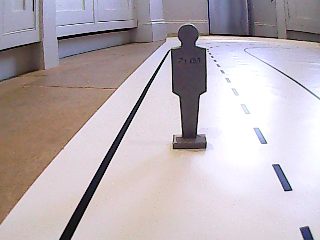

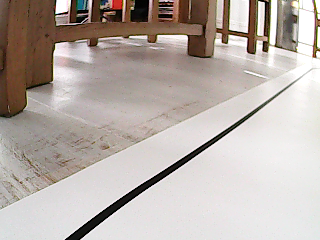

(320, 240)


In [24]:

folder_content = os.listdir(training_image_path)
for item in folder_content[:5]:
    print(item)
img = Image.open("/kaggle/input/machine-learning-in-science-ii-2024/test_data/test_data/1.png")
display(img)
img2 = Image.open("/kaggle/input/machine-learning-in-science-ii-2024/test_data/test_data/2.png")
display(img2)
print(img.size)
img_width = img.size[0]
img_height = img.size[1]
# Get the number of channels
channels = 3 # RGB channels


In [ ]:
def create_cnn_model_v2(input_shape, pool_size=(2, 2)):
    model = Sequential()


    # Use InputLayer to specify the input shape
    model.add(InputLayer(input_shape=input_shape))  
    model.add(BatchNormalization())

    model.add(Conv2D(8, (3, 3), padding='valid', strides=(1, 1), activation='relu', name='Conv1'))
    model.add(Conv2D(16, (3, 3), padding='valid', strides=(1, 1), activation='relu', name='Conv2'))
    model.add(MaxPooling2D(pool_size=pool_size))

    model.add(Conv2D(16, (3, 3), padding='valid', strides=(1, 1), activation='relu', name='Conv3'))
    model.add(Dropout(0.2))

    model.add(Conv2D(32, (3, 3), padding='valid', strides=(1, 1), activation='relu', name='Conv4'))
    model.add(Dropout(0.2))

    model.add(Conv2D(32, (3, 3), padding='valid', strides=(1, 1), activation='relu', name='Conv5'))
    model.add(Dropout(0.2))
    model.add(MaxPooling2D(pool_size=pool_size))

    model.add(Conv2D(64, (3, 3), padding='valid', strides=(1, 1), activation='relu', name='Conv6'))
    model.add(Dropout(0.2))

    model.add(Conv2D(64, (3, 3), padding='valid', strides=(1, 1), activation='relu', name='Conv7'))
    model.add(Dropout(0.2))
    model.add(MaxPooling2D(pool_size=pool_size))

    model.add(Flatten())

    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.5))  # Dropout layer to reduce overfitting

    model.add(Dense(50, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(10, activation='relu'))
    model.add(Dense(1))  # Output layer with 1 neuron for regression tasks

    return model

In [ ]:
batch_size = 128
datagen = ImageDataGenerator(rescale=1./255)  

# Add the full path to the file names
file_path  = "/kaggle/input/machine-learning-in-science-ii-2024/training_data/training_data"
train_df['file_path'] = file_path  + '/' + train_df['image_id'].astype(str) + '.png'

generator = datagen.flow_from_dataframe(
    train_df,
    x_col='file_path',
    y_col='speed',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='raw'
)


In [ ]:
pool_size = (2, 2)
input_shape = (img_height, img_width, 3)
model_2 = create_cnn_model_v2(input_shape)
model_2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])



In [ ]:
num_epochs = 10  # Set the number of training epochs
history = model_2.fit(generator, epochs=num_epochs)

In [ ]:
# Assuming you have defined and compiled your Keras model
